# Teste de Algoritmos Genéticos

## Imports

In [10]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data.loader import DataLoader
from src.data.preprocessor import preprocess_dataset
from src.algorithms.knn_classifier import KNNClassifier
from src.algorithms.genetic_algorithm import GeneticAlgorithm
from src.fitness.accuracy_fitness import create_fitness_function

sns.set_style('whitegrid')
np.random.seed(42)

## Testes

In [11]:
loader = DataLoader(data_root="../data/raw")
X_train_raw, y_train_raw, X_test_raw, y_test_raw = loader.load_colon()

X = np.vstack([X_train_raw, X_test_raw])
y = np.concatenate([y_train_raw, y_test_raw])

print(f"Dataset Colon:")
print(f"  Samples: {X.shape[0]}")
print(f"  Features: {X.shape[1]}")
print(f"  Classes: {np.unique(y, return_counts=True)}")

Carregando conjunto de dados de microarray: COLON-TUMOR
Formato Elvira detectado
Parseando arquivo Elvira: colonTumor.dbc
Número de casos esperados: 62
Encontrados 2001 nós/variáveis
Nó de label: SampleType
Estados do label: ['positive', 'negative']
Extraídos 62 casos
Mapeamento de labels: {'positive': 0, 'negative': 1}
Matriz de dados: X=(62, 2000), y=(62,)
Classes únicas em y: [0 1] (distribuição: [22 40])
Conjunto de dados COLON-TUMOR carregado com sucesso. X_train: (43, 2000), X_test: (19, 2000)
Features: 2000, Samples: 62, Classes: 2
Dataset Colon:
  Samples: 62
  Features: 2000
  Classes: (array([0, 1], dtype=int32), array([22, 40]))


In [12]:
X_train, X_test, y_train, y_test = preprocess_dataset(
    X, y, 
    normalization='standard',
    test_size=0.3, 
    random_state=42
)

print(f"\nConjunto de treino: {X_train.shape}")
print(f"Conjunto de teste: {X_test.shape}")

Dados normalizados com standard
Shape: (62, 2000), Min: -2.0202, Max: 7.4755
Divisão treino/teste: 70/30
Treino: (43, 2000), Teste: (19, 2000)
Distribuição treino: [15 28]
Distribuição teste: [ 7 12]

Conjunto de treino: (43, 2000)
Conjunto de teste: (19, 2000)


In [13]:
knn_baseline = KNNClassifier(k=7, distance_metric="euclidean")
knn_baseline.fit(X_train, y_train)

acc_train_baseline = knn_baseline.score(X_train, y_train)
acc_test_baseline = knn_baseline.score(X_test, y_test)

print(f"KNN Baseline (k=7, todas as features):")
print(f"  Acurácia Treino: {acc_train_baseline:.4f}")
print(f"  Acurácia Teste: {acc_test_baseline:.4f}")
print(f"  Features usadas: {X_train.shape[1]}/{X_train.shape[1]}")

KNN Baseline (k=7, todas as features):
  Acurácia Treino: 0.8837
  Acurácia Teste: 0.8421
  Features usadas: 2000/2000


In [23]:
fitness_function = create_fitness_function(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    k=7,
    metric='euclidean',
    penalty_weight=0.0
)

ga = GeneticAlgorithm(
    population_size=200,    
    generations=50,          
    crossover_rate=0.8,      
    mutation_rate=0.05,      
    tournament_size=5,       
    elitism=5,                 
    random_state=None
)

print("Executando GA...\n")
ga.fit(
    n_features=X_train.shape[1],
    fitness_function=fitness_function,
    verbose=True
)

Executando GA...

Geração 0: Fitness=0.8947, Features=1014/2000
Geração 10: Fitness=0.8947, Features=1014/2000
Geração 20: Fitness=0.8947, Features=1014/2000
Geração 30: Fitness=0.9474, Features=987/2000
Geração 40: Fitness=0.9474, Features=987/2000

Finalizado: Fitness=0.9474, Features=987/2000


In [24]:
selected_features = ga.get_selected_features()
n_selected = len(selected_features)

X_train_selected = ga.transform(X_train)
X_test_selected = ga.transform(X_test)

knn_ga = KNNClassifier(k=7, distance_metric="euclidean")
knn_ga.fit(X_train_selected, y_train)

acc_train_ga = knn_ga.score(X_train_selected, y_train)
acc_test_ga = knn_ga.score(X_test_selected, y_test)

print(f"KNN + GA (k=7, features selecionadas):")
print(f"  Acurácia Treino: {acc_train_ga:.4f}")
print(f"  Acurácia Teste: {acc_test_ga:.4f}")
print(f"  Features selecionadas: {n_selected}/{X_train.shape[1]} ({100*n_selected/X_train.shape[1]:.1f}%)")
print(f"\nMelhoria:")
print(f"  Treino: {acc_train_ga - acc_train_baseline:+.4f}")
print(f"  Teste: {acc_test_ga - acc_test_baseline:+.4f}")
print(f"\nAvaliações de fitness: {fitness_function.get_evaluation_count()}")

KNN + GA (k=7, features selecionadas):
  Acurácia Treino: 0.9070
  Acurácia Teste: 0.9474
  Features selecionadas: 987/2000 (49.4%)

Melhoria:
  Treino: +0.0233
  Teste: +0.1053

Avaliações de fitness: 10000


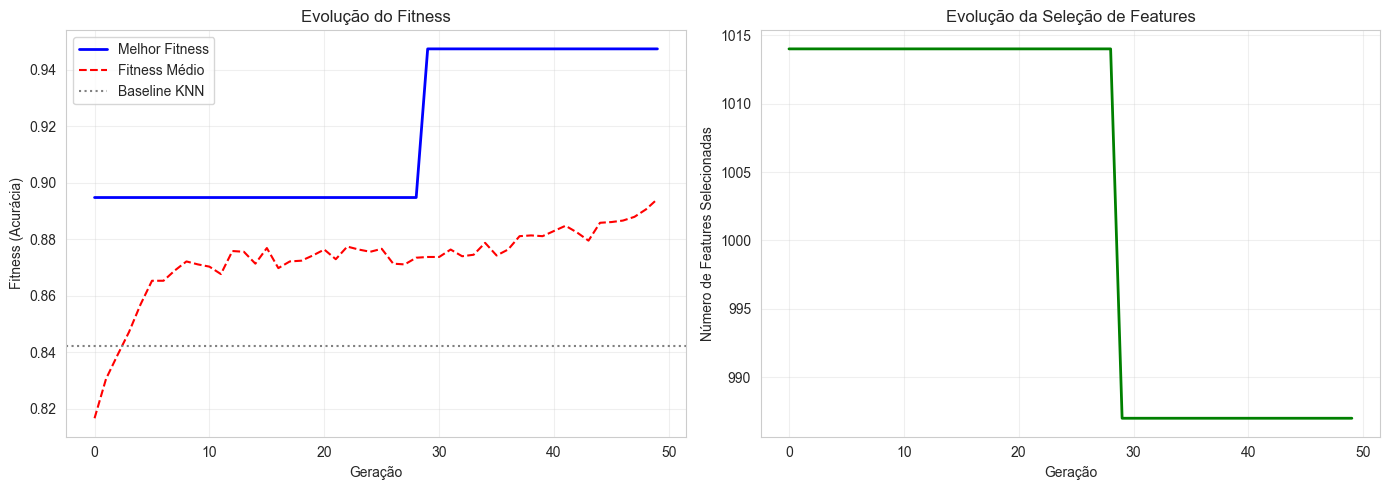

In [25]:
history = ga.get_fitness_history()

generations = [h['generation'] for h in history]
best_fitness = [h['best_fitness'] for h in history]
mean_fitness = [h['mean_fitness'] for h in history]
n_features_selected = [h['n_features_best'] for h in history]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(generations, best_fitness, 'b-', linewidth=2, label='Melhor Fitness')
axes[0].plot(generations, mean_fitness, 'r--', linewidth=1.5, label='Fitness Médio')
axes[0].axhline(y=acc_test_baseline, color='gray', linestyle=':', label='Baseline KNN')
axes[0].set_xlabel('Geração')
axes[0].set_ylabel('Fitness (Acurácia)')
axes[0].set_title('Evolução do Fitness')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(generations, n_features_selected, 'g-', linewidth=2)
axes[1].set_xlabel('Geração')
axes[1].set_ylabel('Número de Features Selecionadas')
axes[1].set_title('Evolução da Seleção de Features')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
print(f"\nÍndices das features selecionadas:")
print(selected_features[:20], "..." if n_selected > 20 else "")


Índices das features selecionadas:
[ 6  7  8 10 12 13 16 17 20 21 22 23 25 29 31 33 35 36 38 39] ...


In [28]:
history = ga.get_fitness_history()

print("Diversidade por geração:")
for i in [0, 10, 20, 29]:
    h = history[i]
    print(f"Gen {i}: Best={h['best_fitness']:.4f}, "
          f"Mean={h['mean_fitness']:.4f}, "
          f"Std={h['std_fitness']:.4f}")

print(f"\nNúmero de features únicas nos top 10 indivíduos:")

final_fitness = ga.fitness_scores
top10_indices = np.argsort(final_fitness)[-10:]
top10_n_features = [np.sum(ga.population[i]) for i in top10_indices]
print(f"Features selecionadas: {top10_n_features}")
print(f"Diversidade: {len(set(top10_n_features))} valores únicos")

Diversidade por geração:
Gen 0: Best=0.8947, Mean=0.8166, Std=0.0337
Gen 10: Best=0.8947, Mean=0.8703, Std=0.0311
Gen 20: Best=0.8947, Mean=0.8763, Std=0.0282
Gen 29: Best=0.9474, Mean=0.8737, Std=0.0316

Número de features únicas nos top 10 indivíduos:
Features selecionadas: [np.int64(995), np.int64(986), np.int64(966), np.int64(1026), np.int64(1005), np.int64(1009), np.int64(999), np.int64(1018), np.int64(996), np.int64(998)]
Diversidade: 10 valores únicos
